In [1]:
import os
import torch
import numpy as np
import torch.nn.functional as F
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random
import sys
from matplotlib import gridspec
from matplotlib import pyplot as plt
import torch
from score_util_pub import *
import json

### For SDXL-Turbo

In [2]:
from diffusers import DDIMScheduler, DiffusionPipeline, AutoPipelineForText2Image
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")

/data3/dahee/anaconda3/envs/t2i_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
# The indices of the channels to be masked
empty_mask = [[] for i in range(7)]
empty_mask = fold_mask(empty_mask)
dummy_mask = {t: empty_mask for t in range(1)}

# The amplification factor for each layer
file_path = f'/path_to_amp_factors/sdxl-turbo/chair/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)

d0 = 1+(data[0][0]-1)*0.3
d1 = 1+(data[0][1]-1)*0.3
d2 = 1+(data[0][2]-1)*0.2
d3 = 1+(data[0][3]-1)*0.2

replace_mask = fold_mask([d0, d1, d2, d3, 1.0, 1.0, 1.0])

# The cutoff for each layer
cutoffs = fold_mask([5.0, 5.0, 5.0, 5.0, 0.0, 0.0, 0.0])

# Set prompt
prompt = 'a creative chair'

In [8]:
seed = 3
set_seed(seed)
out = pipe(
    prompt=prompt, num_inference_steps=1, guidance_scale=0
)
img_ori = out[0].images[0]


set_seed(seed)
out = pipe(
    prompt=prompt, num_inference_steps=1, guidance_scale=0, replace_mask=replace_mask, replace_on='freq', hidden_mask=dummy_mask, cutoff_freq=cutoffs
)
img_ours = out[0].images[0]


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


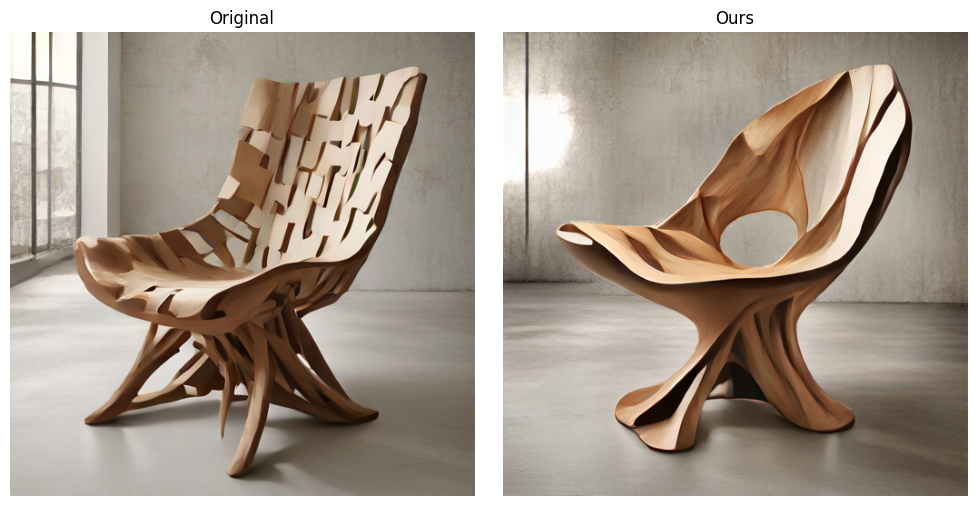

In [9]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(img_ori)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(img_ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()

----

## For SDXL-Lightning

In [10]:
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
# ckpt = "sdxl_lightning_4step_unet.safetensors" # For step4
ckpt = "sdxl_lightning_1step_unet_x0.safetensors" # For step 1

# Load model.
unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float16, variant="fp16").to("cuda")


# pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing") # For step 4
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing", prediction_type="sample") # For step 1


/data3/dahee/anaconda3/envs/t2i_eval/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


In [25]:
# The indices of the channels to be masked
empty_mask = [[] for i in range(7)]
empty_mask = fold_mask(empty_mask)
dummy_mask = {t: empty_mask for t in range(1)}

# The amplification factor for each layer
file_path = f'/path_to_amp_factors/sdxl-light-1/house/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)

d0 = 1+(data[0][0]-1)*0.2
d1 = 1+(data[0][1]-1)*0.2
d2 = 1+(data[0][2]-1)*0.1
d3 = 1+(data[0][3]-1)*0.1

replace_mask = fold_mask([d0, d1, d2, d3, 1.0, 1.0, 1.0])

# The cutoff for each layer
cutoffs = fold_mask([10.0, 5.0, 5.0, 5.0, 0.0, 0.0, 0.0])

# Set prompt
prompt = 'a creative house'

In [26]:
seed = 3
set_seed(seed)
out = pipe(
    prompt=prompt, num_inference_steps=1, guidance_scale=0
)
img_ori = out[0].images[0]


set_seed(seed)
out = pipe(
    prompt=prompt, num_inference_steps=1, guidance_scale=0, replace_mask=replace_mask, replace_on='freq', hidden_mask=dummy_mask, cutoff_freq=cutoffs
)
img_ours = out[0].images[0]


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


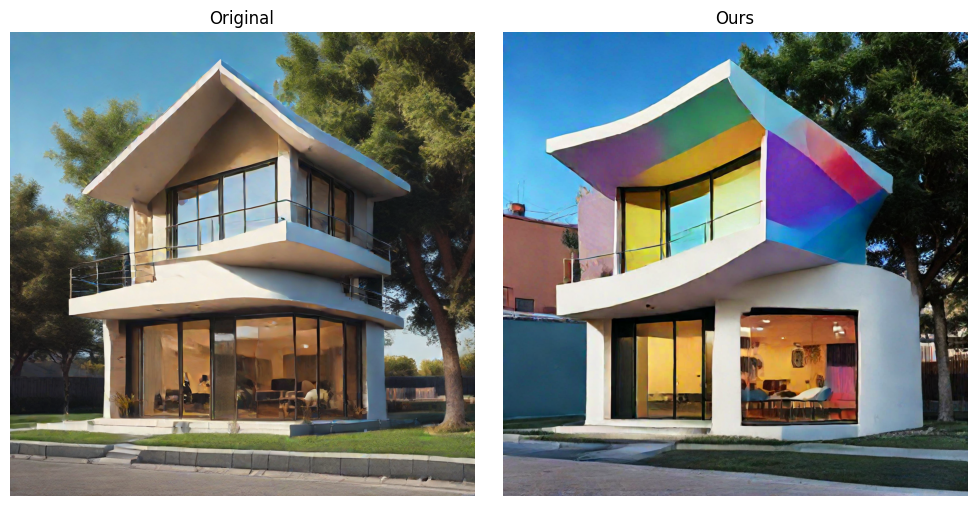

In [27]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(img_ori)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(img_ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()